# Food detection

This notebook's objective is to use transfer learning to train a network in detecting food. In particular, we'll use the [UEC FOOD 256](http://foodcam.mobi/dataset256.html) dataset and [YOLOv5](https://github.com/ultralytics/yolov5).


References:
- https://github.com/ultralytics/yolov5/wiki/Train-Custom-Data
- https://blog.roboflow.com/how-to-train-yolov5-on-a-custom-dataset/
- https://www.curiousily.com/posts/object-detection-on-custom-dataset-with-yolo-v5-using-pytorch-and-python/

## Libraries

In [1]:
import gc
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from pathlib import Path
import seaborn as sns
%matplotlib inline

from IPython.display import Image, clear_output  # to display images

import PIL
from PIL import ImageDraw

from sklearn.model_selection import train_test_split

import torch
clear_output()

In [2]:
print('Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

Using torch 1.6.0+cu101 _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15079MB, multi_processor_count=40)


## Dataset Preparation

In [4]:
!wget -q http://foodcam.mobi/dataset256.zip
!unzip -q dataset256.zip

Let's load all image paths and bounding boxes into a Pandas' DataFrame. We'll extract the food categories and their corresponding IDs into a Pandas' Series too.

In [5]:
data = []
for root, dirs, files in os.walk('UECFOOD256'): # dirs not in order
    if 'bb_info.txt' in files:
        df = pd.read_csv(os.path.join(root, 'bb_info.txt'), sep=' ')
        df['img'] = df['img'].apply(lambda x: root + '/' + str(x) + '.jpg')
        df['label'] = int(root.split('/')[-1])
        data.append(df)

data = pd.concat(data, ignore_index=True)
data.head()

,img,x1,y1,x2,y2,label
0,UECFOOD256/107/184103.jpg,22,30,465,446,107
1,UECFOOD256/107/7848.jpg,30,16,555,406,107
2,UECFOOD256/107/183030.jpg,25,47,478,408,107
3,UECFOOD256/107/183152.jpg,18,23,557,330,107
4,UECFOOD256/107/183066.jpg,42,79,571,383,107


In [6]:
categories = pd.read_csv('UECFOOD256/category.txt', sep='\t', index_col='id', squeeze=True)
print(f'Number of food categories: {categories.shape[0]}\n')
categories.head()

Number of food categories: 256



id
1                       rice
2               eels on rice
3                      pilaf
4    chicken-'n'-egg on rice
5        pork cutlet on rice
Name: name, dtype: object

In [7]:
print(f'Total number of bounding boxes: {data.shape[0]}')

Total number of bounding boxes: 31645


Let's visualize some images and the bounding boxes.

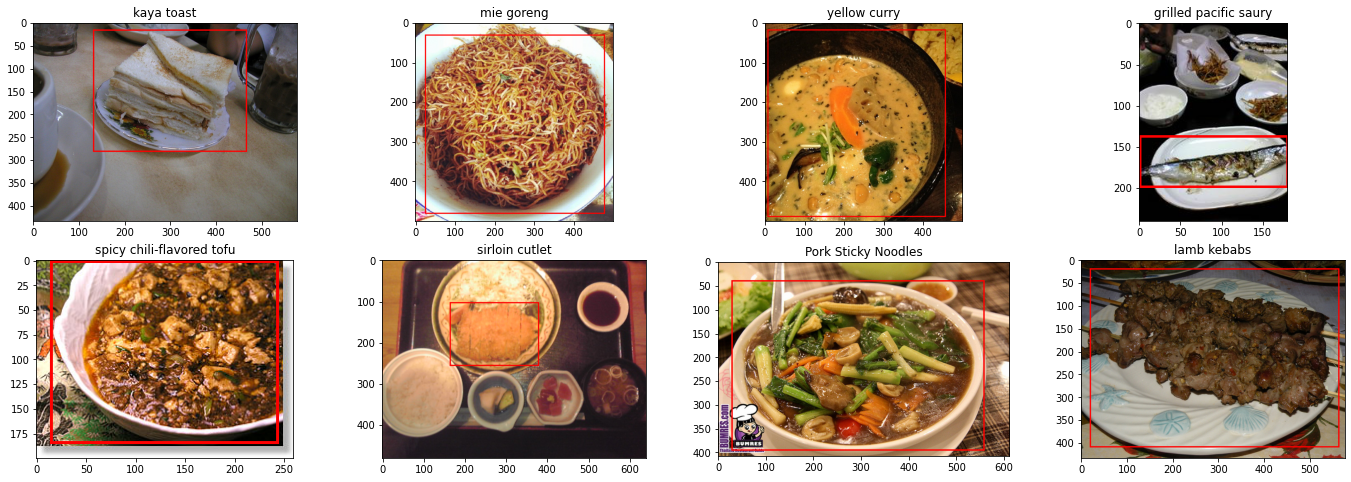

In [8]:
samples = data.sample(8)

fig, axs = plt.subplots(2, 4, figsize=(24, 8))
for i in range(2):
    for j in range(4):
        sample = samples.iloc[i*4 + j, :]
        img = PIL.Image.open(sample['img'])
        draw = ImageDraw.Draw(img)
        draw.rectangle(sample['x1':'y2'], outline='red', width=3)
        axs[i][j].imshow(np.array(img))
        axs[i][j].set_title(categories[sample['label']])

Now let's check the image sizes.

In [9]:
sizes = np.empty((data.shape[0], 2), dtype=int)

for i, path in data['img'].items():
    img = PIL.Image.open(path)
    sizes[i, :] = img.size

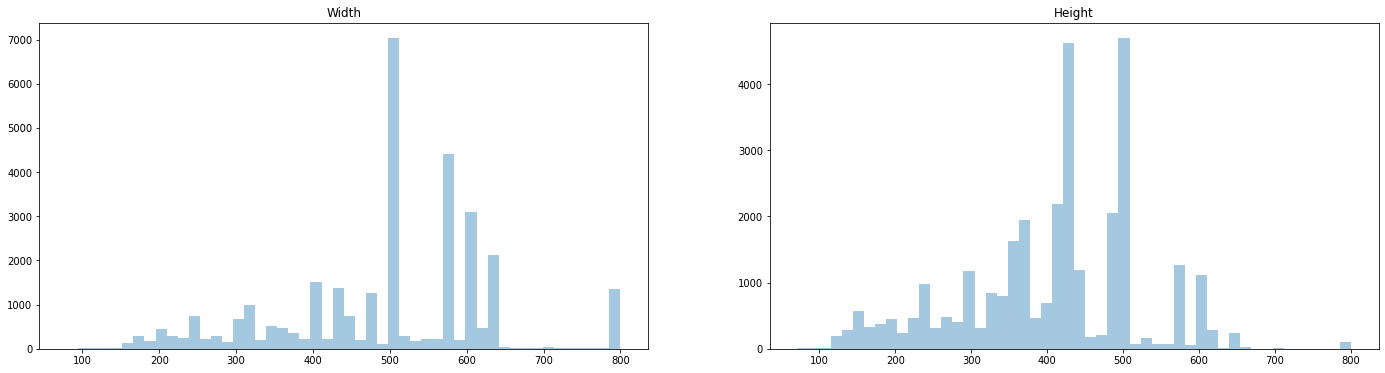

In [10]:
sizes.mean(axis=0)

fig, axs = plt.subplots(1, 2, figsize=(24, 6))
sns.distplot(sizes[:, 0], kde=False, norm_hist=False, ax=axs[0])
axs[0].set_title('Width')
sns.distplot(sizes[:, 1], kde=False, norm_hist=False, ax=axs[1])
_ = axs[1].set_title('Height')

The sizes are pretty different but we need to resize them to the same size. Let's resize them all to 320 during training (to be able to cache all images).

We also need to reorganize the dataset as what YOLOv5 would expect, i.e. 1 folder each for the train and validation images as well as 1 folder each for the corresponding bouding boxes. The bounding boxes have to be in the darknet format. The labels also need to start from 0.

In addition to the train and validation sets, we'll also reserve a small subset of images for the test set.

In [4]:
def to_darknet_format(df, out_path, dataset_type):
    dirname = []
    if dataset_type == 'train' or dataset_type == 'val' or dataset_type == 'test':
        dirname.append(dataset_type)
    else:
        raise RuntimeError(f'{dataset_type} is not a valid argument.')

    imgs_path = os.path.join(out_path, 'images', *dirname)
    if not os.path.exists(imgs_path):
        os.makedirs(imgs_path)
    labels_path = os.path.join(out_path, 'labels', *dirname)
    if not os.path.exists(labels_path):
        os.makedirs(labels_path)

    for row in df.itertuples():
        new_img_name = row.img.replace('/', '-')
        new_img_file = os.path.join(imgs_path, new_img_name)
        if os.path.isfile(row.img):
            os.rename(row.img, new_img_file)

        img = PIL.Image.open(new_img_file)
        width, height = img.size
        if row.img == 'UECFOOD256/150/37571.jpg': # This image's bounding box has the width and height inverted
            x = (row.y1 + row.y2) / (2 * width)
            y = (row.x1 + row.x2) / (2 * height)
            w = (row.y2 - row.y1) / width
            h = (row.x2 - row.x1) / height
        else:
            x = (row.x1 + row.x2) / (2 * width)
            y = (row.y1 + row.y2) / (2 * height)
            w = (row.x2 - row.x1) / width
            h = (row.y2 - row.y1) / height
        label_file = os.path.join(labels_path, new_img_name[:-4] + '.txt')
        with open(label_file, 'a') as f:
            f.write(f'{row.label - 1} {x} {y} {w} {h}\n') # Class labels start from 0

# Split data while making sure images with multiple bounding boxes
# have their bounding boxes in the same dataset
imgs_unique = data['img'].drop_duplicates()
train, test = train_test_split(imgs_unique, test_size=0.05)
train, val = train_test_split(train, test_size=0.1)
train = data[data['img'].isin(train)]
val = data[data['img'].isin(val)]
test = data[data['img'].isin(test)]

train.to_csv('train.csv', index=False)
val.to_csv('val.csv', index=False)
test.to_csv('test.csv', index=False)

to_darknet_format(train, 'UEC_FOOD_256', 'train')
to_darknet_format(val, 'UEC_FOOD_256', 'val')
to_darknet_format(test, 'UEC_FOOD_256', 'test')

## Model (YOLOv5s)

Load YOLOv5 from the official repo and the YAML config files located in the same folder as this notebook. We'll use the YOLOv5s version which is less accurate but faster to train (smaller architecture) and faster at inference time (interesting for mobile devices).


In [11]:
!git clone https://github.com/ultralytics/yolov5  # clone repo
!pip install -qr yolov5/requirements.txt  # install dependencies
clear_output()

In [13]:
!mv uec_food_256.yaml yolov5/data/uec_food_256.yaml
!mv yolov5s.yaml yolov5/models/yolov5s.yaml
%cd yolov5

/content/yolov5


## Training

Let's train the YOLOv5s model using the provided script for 300 epochs starting from the pretrained checkpoint.

In [15]:
!python train.py --img 320 --batch 64 --epochs 300 --data data/uec_food_256.yaml --cfg models/yolov5s.yaml \
    --weights yolov5s.pt --cache 2>&1 | tee train.log

﻿Using torch 1.6.0+cu101 _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15079MB, multi_processor_count=40)

Using CUDA device0 _CudaDeviceProperties(name='Tesla T4', total_memory=15079MB)

Namespace(adam=False, batch_size=64, bucket='', cache_images=True, cfg='models/yolov5s.yaml', data='data/uec_food_256.yaml', device='', epochs=300, evolve=False, global_rank=-1, hyp='data/hyp.scratch.yaml', image_weights=False, img_size=[320, 320], local_rank=-1, logdir='runs/', multi_scale=False, name='', noautoanchor=False, nosave=False, notest=False, rect=False, resume=False, single_cls=False, sync_bn=False, total_batch_size=64, weights='yolov5s.pt', workers=8, world_size=1)
Start Tensorboard with "tensorboard --logdir runs/", view at http://localhost:6006/
2020-09-11 06:04:25.475867: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
Hyperparameters {'lr0': 0.01, 'lrf': 0.2, 'momentum': 0.937, 'weight_decay'

Let's zip the results for easy downloading and plot.

In [ ]:
%%shell
cd runs; zip -qr exp0 exp0; cd ..

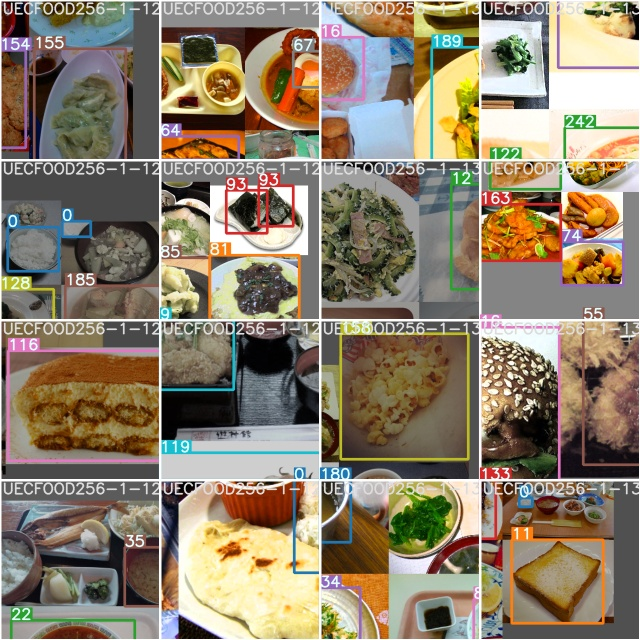

In [16]:
Image(filename='runs/exp0/train_batch1.jpg', width=900)  # view augmented training mosaics

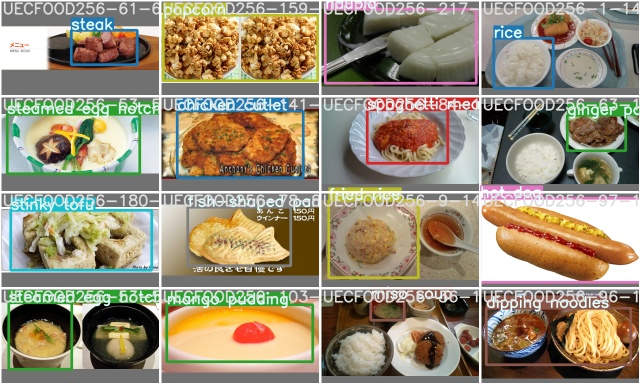

In [17]:
Image(filename='runs/exp0/test_batch0_gt.jpg', width=900)  # view test image labels

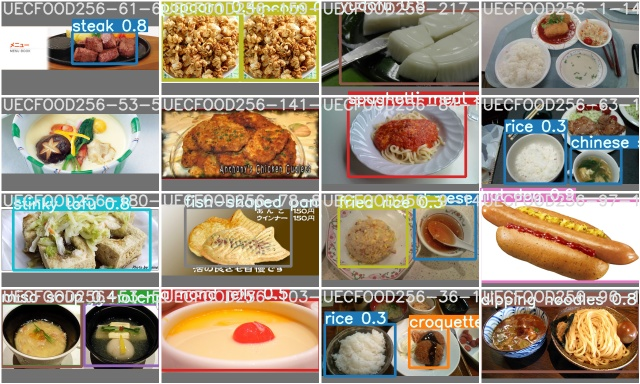

In [18]:
Image(filename='runs/exp0/test_batch0_pred.jpg', width=900)  # view test image predictions

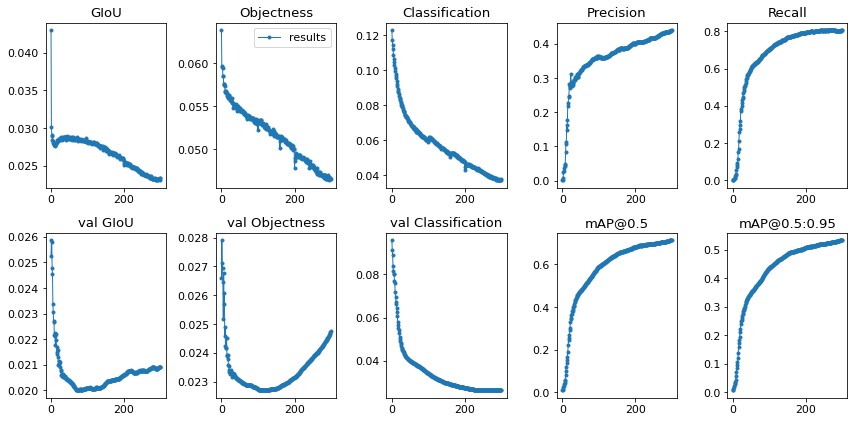

In [9]:
from utils.general import plot_results
plot_results(save_dir='runs/exp0')  # plot results.txt files as results.png

We achieved a **71.4% mAP\@0.5** after 300 epochs. Training more might improve this result. However, the GIoU and Objectness losses on the validation set will most probably continue to increase. Only the classification loss might continue to decrease.

## Inference

We'll evaluate the model with the test set and show some images with the predicted bounding boxes.

In [7]:
!python test.py --img 320 --batch 64 --data data/uec_food_256.yaml --weights runs/exp0/weights/best.pt \
    --task test --verbose 2>&1 | tee test.log

Using CUDA device0 _CudaDeviceProperties(name='Tesla T4', total_memory=15079MB)

Model Summary: 140 layers, 7.93425e+06 parameters, 6.61683e+06 gradients
Scanning images: 100%|██████████| 1570/1570 [00:00<00:00, 2641.10it/s]
Scanning labels ../UEC_FOOD_256/labels/test.cache (1570 found, 0 missing, 0 empty, 0 duplicate, for 1570 images): 1570it [00:00, 18087.74it/s]Namespace(augment=False, batch_size=64, conf_thres=0.001, data='data/uec_food_256.yaml', device='', img_size=320, iou_thres=0.65, merge=False, save_json=False, save_txt=False, single_cls=False, task='test', verbose=True, weights=['runs/exp0/weights/best.pt'])
Fusing layers... 

               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 25/25 [00:13<00:00,  1.82it/s]                 all    1.57e+03    1.58e+03       0.431       0.815       0.727       0.564
                rice    1.57e+03          25       0.335        0.96       0.385       0.265
        eels on rice    1.5

Overall, the results are similar to the ones for the validation set. We can also notice that some food categories are particularly hard to detect (e.g. rice, pilaf, chip butty, sauteed vegetables,...).

The inference speed is 1.2 ms per image (for this Colab session's hardware).

Let's visualize some predictions now.

In [8]:
!python detect.py --weights runs/exp0/weights/best.pt --img 320 --conf 0.4 --source ../UEC_FOOD_256/images/test/ \
    --output ../UEC_FOOD_256/output > detect.log 2>&1
!tail detect.log

image 1563/1570 /content/UEC_FOOD_256/images/test/UECFOOD256-99-12607.jpg: 320x256 1 kamameshis, Done. (0.013s)
image 1564/1570 /content/UEC_FOOD_256/images/test/UECFOOD256-99-12630.jpg: 320x320 1 mixed rices, Done. (0.012s)
image 1565/1570 /content/UEC_FOOD_256/images/test/UECFOOD256-99-12632.jpg: 256x320 1 mixed rices, Done. (0.013s)
image 1566/1570 /content/UEC_FOOD_256/images/test/UECFOOD256-99-12634.jpg: 320x320 1 mixed rices, Done. (0.013s)
image 1567/1570 /content/UEC_FOOD_256/images/test/UECFOOD256-99-12645.jpg: 256x320 1 mixed rices, Done. (0.013s)
image 1568/1570 /content/UEC_FOOD_256/images/test/UECFOOD256-99-12661.jpg: 256x320 1 sukiyakis, Done. (0.012s)
image 1569/1570 /content/UEC_FOOD_256/images/test/UECFOOD256-99-13956.jpg: 256x320 Done. (0.011s)
image 1570/1570 /content/UEC_FOOD_256/images/test/UECFOOD256-99-5135.jpg: 320x256 1 sweet and sour porks, Done. (0.013s)
Results saved to ../UEC_FOOD_256/output
Done. (34.431s)


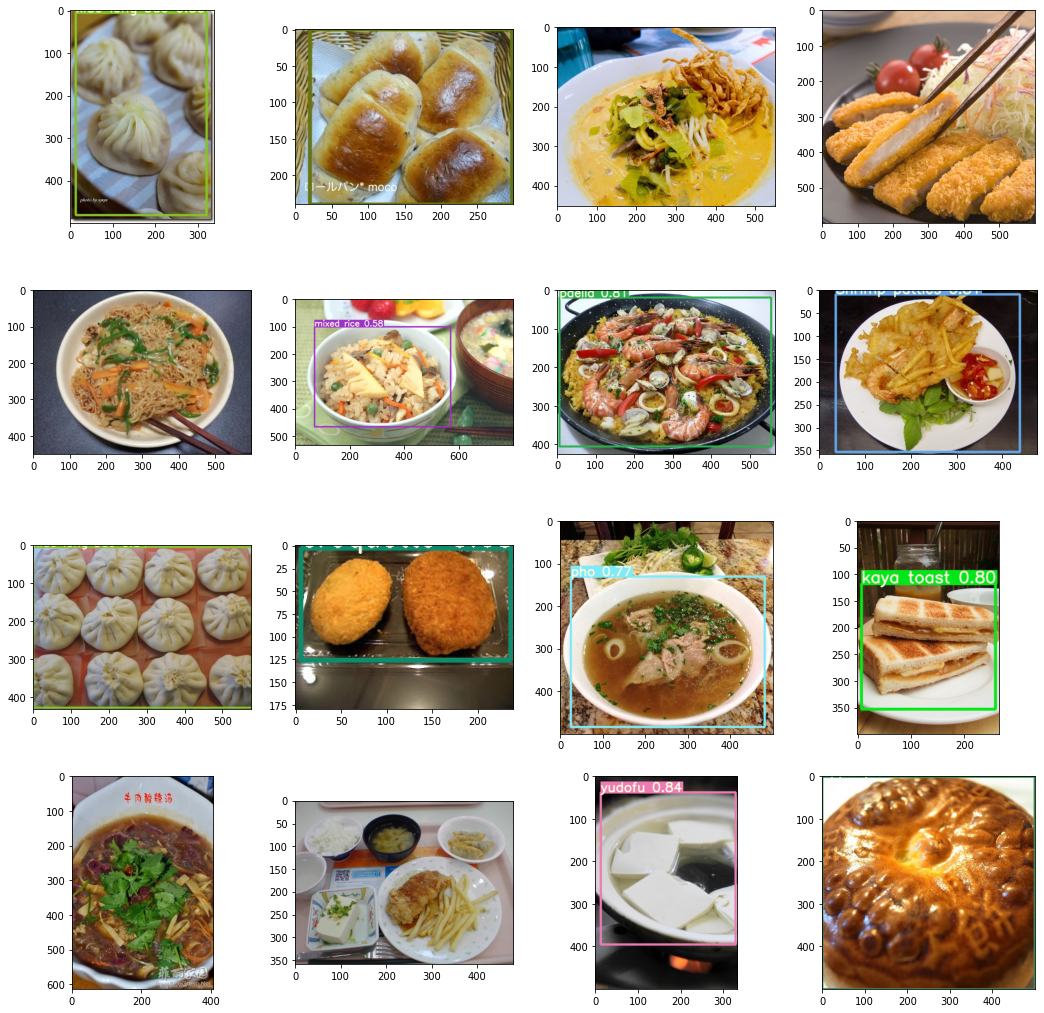

In [9]:
img_paths = list(Path("../UEC_FOOD_256/output").glob('*.jpg'))
samples = img_paths[:16]

fig, axs = plt.subplots(4, 4, figsize=(18, 18))
for i in range(4):
    for j in range(4):
        img = PIL.Image.open(samples[i*4+j])
        axs[i][j].imshow(np.array(img))

- Some images have no detections.
- We can also have multiple detected food categories overlapping (2 labels for the same food). This happens when the model predict 2 or more categories with a confidence higher than the specified threshold. This could be improved by keeping only the highest predicted class above the threshold.
- The predicted bounding boxes enclose pretty well the dishes.

Fine-tuning pre-trained YOLOv5s to detect different food dishes yields interesting results. It does not require long hours of training to achieve good results. However, food detection remains a difficult challenge. Some dishes seem to be particularly hard to detect with a high confidence.